Script to compare some results from the full year and representative optimization using a MILP formulation.

In [10]:
from __future__ import division

import logging
import time

import pandas as pd
from pkg_resources import resource_filename
from pyomo.core.base import ConcreteModel, Objective, Constraint, minimize
from pyomo.opt import SolverFactory

import modesto.utils as ut
from misc.SDH_Conference_TestCases import CaseFuture
from modesto.main import Modesto

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

DATAPATH = resource_filename('modesto', 'Data')

from runOpt import get_json

from RepresentativeWeeks import representative, solve_repr, get_network_loss

In [2]:
VWat = 75000
solArea = 150000
VSTC = 100000

In [9]:
sellist = get_json('C:/Users/u0094934/Research/TimeSliceSelection/Scripts/solutions7.txt')
selection = sellist[8]

# selection = OrderedDict([(10, 2.0), (48, 12.0), (74, 2.0), (100, 10.0),
# (180, 5.0), (188, 7.0), (224, 5.0), (326, 9.0)])
time_step = 3600 * 6
duration_repr = 7
model, optimizers = representative(duration_repr=duration_repr,
                                   selection=selection, VWat=VWat, solArea=solArea, VSTC=VSTC, time_step=time_step)

begin = time.clock()
solve_repr(model, probe=False, solver='gurobi')
print 'Solving time {}'.format(time.clock()-begin)

Writing time: 4.97293331243
Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter ImproveStartTime to 10.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 26239 rows, 19649 columns and 54093 nonzeros
Variable types: 18305 continuous, 1344 integer (1344 binary)
Coefficient statistics:
  Matrix range     [6e-06, 2e+05]
  Objective range  [2e-02, 1e+01]
  Bounds range     [1e+00, 2e+08]
  RHS range        [7e-16, 7e+07]
Presolve removed 18735 rows and 12626 columns
Presolve time: 0.10s
Presolved: 7504 rows, 7023 columns, 23099 nonzeros
Variable types: 5902 continuous, 1121 integer (1121 binary)

Root relaxation: objective 1.296112e+08, 18122 iterations, 3.23 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.2961e+08    0 

In [7]:
begin = time.clock()
full_model = CaseFuture.setup_opt(time_step=6*3600)
full_model.change_param(node='SolarArray', comp='solar', param='area', val=solArea)
full_model.change_param(node='SolarArray', comp='tank', param='volume', val=VSTC)
full_model.change_param(node='WaterscheiGarden', comp='tank', param='volume', val=VWat)

full_model.change_param(node='Production', comp='backup', param='ramp', val=0)
full_model.change_param(node='Production', comp='backup', param='ramp_cost', val=0)

full_model.compile('20140101')
full_model.set_objective('energy')
print 'Writing time: {}'.format(time.clock() - begin)


begin = time.clock()
full_model.solve(tee=True, mipgap=0.02, solver='gurobi', probe=True)
print 'Solving time: {}'.format(time.clock() - begin)

Writing time: 5.09660052732
Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.02
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter ImproveStartTime to 10.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 113897 rows, 81770 columns and 227785 nonzeros
Variable types: 73010 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [6e-06, 2e+05]
  Objective range  [6e-03, 1e+00]
  Bounds range     [1e+00, 2e+08]
  RHS range        [6e-16, 7e+07]
Presolve removed 88855 rows and 59120 columns
Presolve time: 0.31s
Presolved: 25042 rows, 22650 columns, 78473 nonzeros
Variable types: 15349 continuous, 7301 integer (7301 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   51969    1.4314917e+08   3.010383e+06   0.000000e+00      5s
   60393    1.4321603e+08   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 1.4321

## Heat losses

[6438.7471518724, 9216.5184096246, 9552.8334800122, 10086.249721186601, 6486.874090183301, 12065.4824270778, 10997.3570273693, 8204.5958403292]


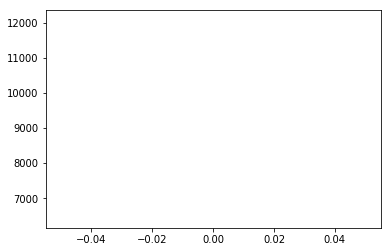

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()

repr_loss = [sum(optmodel.get_result('heat_loss_tot', node=None, comp=pip, check_results=False).sum() / 1000 for pip in
        ['backBone', 'servWat',
         'servTer',
         'servPro',
         'servSol',
         'servBox']) for startday, optmodel in optimizers.iteritems()]

print repr_loss

for i in repr_loss:
    axs.plot(i)

In [ ]:
# ## Post-processing

# In[ ]:

import matplotlib.pyplot as plt
import numpy as np

t_amb = ut.read_time_data(DATAPATH, name='Weather/extT.csv',
                          expand=True)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(selection))]

coli = 0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
for startday, reps in selection.iteritems():
    res = sum(optimizers[startday].get_result('heat_flow', node=node,
                                              comp='tank',
                                              check_results=False) for node in
              ['SolarArray', 'WaterscheiGarden', 'TermienWest'])
    ax1.plot(res, color=colors[coli],
             label='S {} R {}'.format(startday, reps))
    ax1.plot(optimizers[startday].get_result('heat_flow', node='SolarArray',
                                             comp='solar',
                                             check_results=False),
             color=colors[coli], linestyle=':')
    ax1.plot(sum(optimizers[startday].get_result('heat_flow', node=node,
                                                 comp='neighb',
                                                 check_results=False) for node in
                 ['TermienWest', 'WaterscheiGarden', 'TermienWest']),
             color=colors[coli], linestyle='-.')
    ax1.plot(optimizers[startday].get_result('heat_flow', node='Production',
                                             comp='backup',
                                             check_results=False),
             color=colors[coli], linestyle='--')

    print 'start_day:', str(startday)
    res = optimizers[startday].get_component(name='tank',
                                             node='SolarArray').get_heat_stor()
    start = pd.Timestamp('20140101') + pd.Timedelta(days=startday)
    print start
    index = pd.DatetimeIndex(start=start, freq=pd.Timedelta(seconds=time_step), periods=len(res))
    ax2.plot(index, res, color=colors[coli],
             label='S {} R {}'.format(startday, reps))

    ax3.plot(optimizers[startday].get_result('heat_loss_ct', node='SolarArray',
                                             comp='tank',
                                             check_results=False))
    ax3b = ax3.twinx()
    ax3b.plot(-t_amb['Te'], linestyle=':')
    coli += 1

fig.tight_layout()

# In[ ]:
fig, ax = plt.subplots()
startdate = pd.Timestamp('20140101')
nextdate = startdate

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(selection))]

coli = 0

for startday, reps in selection.iteritems():
    res = optimizers[startday].get_component(name='tank',
                                             node='SolarArray').get_soc()
    index = pd.DatetimeIndex(start=nextdate, freq=pd.Timedelta(seconds=time_step), periods=len(res))
    ax.plot(index, res, color=colors[coli], label=str(startday))
    nextdate = nextdate + pd.Timedelta(days=duration_repr * reps)
    coli += 1

ax.legend()
plt.gcf().autofmt_xdate()

fig1 = plot_representative(
    optimizers, selection, duration_repr=duration_repr, time_step=time_step)